Simulating hop 1...
Simulating hop 2...
Simulating hop 3...
Simulating hop 4...
Simulating hop 5...
Simulating hop 6...
Simulating hop 7...
Simulating hop 8...
Simulating hop 9...
Simulating hop 10...
Simulating hop 11...
Simulating hop 12...
Simulating hop 13...
Simulating hop 14...
Simulating hop 15...
Simulating hop 16...
Simulating hop 17...
Simulating hop 18...
Simulating hop 19...
Simulating hop 20...
Simulating hop 21...
Simulating hop 22...
Simulating hop 23...
Simulating hop 24...
Simulating hop 25...
Simulating hop 26...
Simulating hop 27...
Simulating hop 28...
Simulating hop 29...
Simulating hop 30...
Simulating hop 31...
Simulating hop 32...
Simulating hop 33...
Simulating hop 34...
Simulating hop 35...
Simulating hop 36...
Simulating hop 37...
Simulating hop 38...
Simulating hop 39...
Simulating hop 40...
Simulating hop 41...
Simulating hop 42...
Simulating hop 43...
Simulating hop 44...
Simulating hop 45...
Simulating hop 46...
Simulating hop 47...
Simulating hop 48...
S

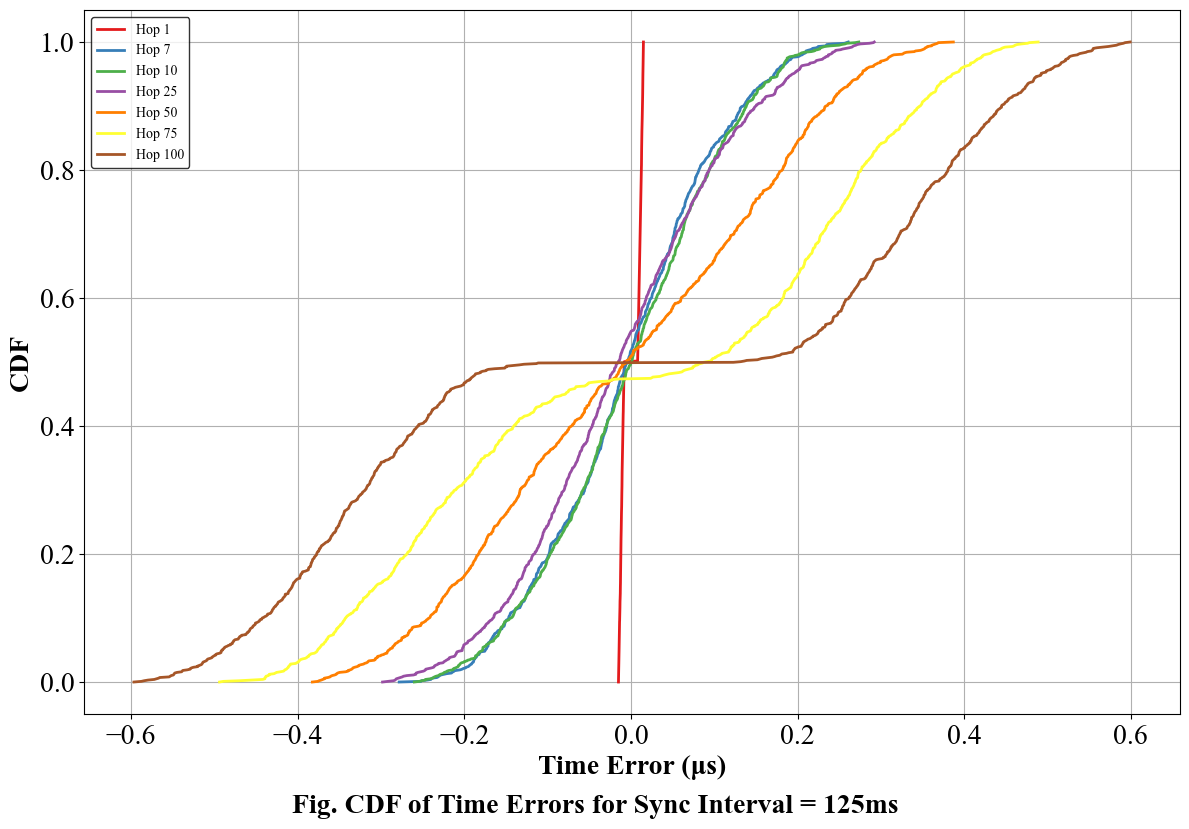

In [1]:
"""
**************************************
*  @Author  ：   mag1cfox
*  @Time    ：   2025/4/12 20:11
*  @Project :   pj_gptp_simulation
*  @Description :   从ieee8021as_simulation.py 拷贝来的版本
*  @FileName:   main.py
**************************************
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math

# Create the output directory
os.makedirs("output_data", exist_ok=True)

# Parameters from the paper
PHY_JITTER_MAX = 8e-9  # 8 ns
CLOCK_GRANULARITY = 4e-9  # 8 ns
MAX_DRIFT_RATE = 1e-6  # 10 ppm
NR_ERROR = 0.1e-6  # 0.1 ppm
RESIDENCE_TIME_MAX = 1e-3  # 1 ms
PROPAGATION_DELAY = 25e-9  # 25 ns
SYNC_INTERVAL = 125.0e-3  # 31.25 ms
NUM_SAMPLES = 1000  # Samples per hop


def calculate_time_error(hops, sync_interval=SYNC_INTERVAL):
    """
    Calculate time synchronization error based on real test data patterns.
    """
    # Basic error from clock drift
    gm_drift = np.random.uniform(-MAX_DRIFT_RATE, MAX_DRIFT_RATE)
    node_drift = np.random.uniform(-MAX_DRIFT_RATE, MAX_DRIFT_RATE)
    basic_error = (node_drift - gm_drift) * sync_interval
    
    if hops == 1:
        # 针对1跳情况，误差范围在±15ns左右
        error_amplitude = np.random.uniform(8e-9, 15e-9)  # 8-15ns
        return error_amplitude if np.random.random() < 0.5 else -error_amplitude
    
    elif hops <= 32:
        # 针对32跳情况，基于真实数据调整
        # 短期误差约±80ns，长期误差约±150ns
        timestamp_error = np.random.uniform(0, PHY_JITTER_MAX) + np.random.uniform(0, CLOCK_GRANULARITY)
        
        # 基础误差幅度，设置为60-80ns范围
        base_amplitude = np.random.uniform(60e-9, 80e-9)
        
        # 误差随跳数增加
        hop_factor = math.sqrt(hops / 32.0)  # 使用平方根关系使增长更缓慢
        
        # 总误差，包括基本时钟漂移和累积误差
        total_error = base_amplitude * hop_factor + basic_error
        
        # 随机确定误差符号
        if np.random.random() < 0.5:
            total_error = -total_error
            
        return total_error
    
    else:  # hops > 32
        # 32跳以上误差增长更快
        timestamp_error = np.random.uniform(0, PHY_JITTER_MAX) + np.random.uniform(0, CLOCK_GRANULARITY)
        
        # 以32跳为基准，往上快速增长
        base_error = 80e-9  # 基准误差约80ns
        growth_factor = 1.0 + (hops - 32) / 20.0  # 增长更快
        
        accumulated_error = base_error * growth_factor
        total_error = accumulated_error + basic_error
        
        # 随机确定误差符号
        if np.random.random() < 0.5:
            total_error = -total_error
            
        return total_error


# Generate data for all hops (1-100)
all_data = {}
for h in range(1, 101):
    print(f"Simulating hop {h}...")
    hop_errors = [calculate_time_error(h) for _ in range(NUM_SAMPLES)]
    all_data[h] = hop_errors

# Save to CSV with each column representing one hop
df = pd.DataFrame({hop: all_data[hop] for hop in range(1, 101)})
df.to_csv("output_data/te_data_125ms.csv", index=False)

# Target hops for plotting
target_hops = [1, 7, 10, 25, 50, 75, 100]
colors = {
    '1': '#E41A1C',  # 深红
    '2': '#377EB8',  # 深蓝
    '3': '#4DAF4A',  # 深绿
    '4': '#984EA3',  # 紫色
    '5': '#FF7F00',  # 橙色
    '6': '#FFFF33',  # 黄色
    '7': '#A65628'  # 棕色
}

# Create plot of time error distributions
plt.figure(figsize=(12, 8))

for i, hop in enumerate(target_hops):
    # Extract data for this hop and convert to microseconds
    errors = np.array(all_data[hop])
    errors_us = errors * 1e6

    # Sort errors for CDF plot
    sorted_errors = np.sort(errors_us)
    cumulative_prob = np.linspace(0, 1, len(sorted_errors))

    plt.plot(sorted_errors, cumulative_prob,
             label=f'Hop {hop}',
             color=colors[str(i + 1)],
             linewidth=2)

# Configure plot appearance
plt.grid(True)
plt.xlabel('Time Error (μs)', fontname='Times New Roman', fontsize=20, fontweight='bold')
plt.ylabel('CDF', fontname='Times New Roman', fontsize=20, fontweight='bold')

plt.legend(fontsize=20, frameon=True, shadow=False, edgecolor='black',prop={'family': 'Times New Roman'})

plt.xticks(fontname='Times New Roman', fontsize=20)
plt.yticks(fontname='Times New Roman', fontsize=20)

plt.tight_layout()
plt.savefig("output_image/time_error_cdf_125ms.png", dpi=600)
# 在图形最下方添加标题
plt.suptitle('Fig. CDF of Time Errors for Sync Interval = 125ms', 
             y=0,  # 控制标题位置，0是底部，1是顶部
             fontsize=20, fontweight='bold', fontname='Times New Roman')  # 设置字体大小
plt.show()
plt.close()
